# Use of EXIOBASE3.8
We will illustrate here the use of EXIOBASE by calculating EU GHG emissions from different perspectives.

Some of these results are used in the "Luxembourg in Transition" report.

Note: there is a bit of experimentation going on, for example the regionalization of the stressor matrix.

<thomas.gibon@list.lu>

Credit <maxime.agez@polymtl.ca> for the stressor extensions and characterization data

In [1]:
# Let's get comfortable first
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pymrio as mr
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import SPA
from matplotlib.patches import Rectangle

Import the data. You'll need to have downloaded EXIOBASE 3.8 files from https://zenodo.org/record/4277368 into `EXIOBASE_PATH`.
I recommend using the command described below.
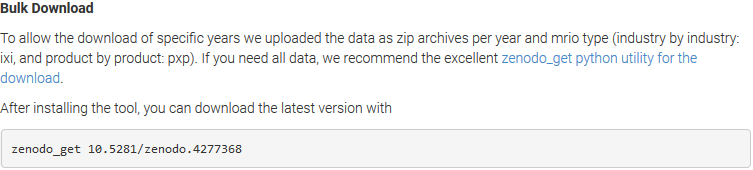

Then specify a year you want to work with. Note: in the 3.8 version, year 2019 has some issues, specifically for EU and Denmark in particular. You may want to choose another year instead.

The original characterization matrix is from https://zenodo.org/record/3955079/

...and you can find the stressors extension and characterization data at https://figshare.com/articles/dataset/Additional_environmental_extensions_for_EXIOBASE3_based_on_USEEEIO/12471278/1

In [3]:
year = 2018
EXIOBASE_PATH = '../exiobase/EXIOBASE3.8/'
# EXIOBASE_PATH = '../exiobase/'

Then, just import the IO system with `pymrio`:

In [ ]:
io = mr.parse_exiobase3(path=EXIOBASE_PATH+'IOT_{}_pxp.zip'.format(year))

Import the population data.

In [ ]:
population = pd.read_csv(EXIOBASE_PATH+'exiobase_population.txt',sep='\t',index_col=0)
io.population=pd.DataFrame(columns=['population'], data=population.loc[year].values, index=population.columns).T

In [ ]:
io.calc_all()

Import additional stressors.

In [ ]:
# Credit to Maxime Agez for the stressor extension
stressors=pd.read_csv(EXIOBASE_PATH+'Expanded_S.csv',
                     index_col=[0],
                     header=[0,1])

In [ ]:
stressors.shape

In [ ]:
stressors.columns=io.A.columns
short_S=io.satellite.S
short_S.shape

In [ ]:
io.satellite.S=pd.concat([short_S,stressors],axis=0)

In [ ]:
io.satellite.F=io.satellite.S.mul(io.x['indout'])

In [ ]:
F_Y_padding=pd.DataFrame(np.zeros([stressors.shape[0],io.satellite.F_Y.shape[1]]),
                        index=stressors.index,
                        columns=io.satellite.F_Y.columns)

In [ ]:
io.satellite.F_Y=io.satellite.F_Y.append(F_Y_padding)

Run the various calculations (satellite factors, footprint reports, ...)

Import characterization.

In [ ]:
Q_base=pd.read_csv(EXIOBASE_PATH+'C_exio_IW.csv',
             index_col=[0])
padding=short_S.shape[0]-Q_base.shape[1]
Q_energy=pd.DataFrame(np.zeros([Q_base.shape[0],padding]),
                     index=Q_base.index,
                     columns=short_S.index[-padding:])
Q_ext=pd.read_csv(EXIOBASE_PATH+'C_expansion_IW.csv',
             index_col=[0])

In [ ]:
Q_base.shape

In [ ]:
Q=pd.concat([Q_base,Q_energy,Q_ext],axis=1)
Q.shape

In [ ]:
impact = dict()

In [ ]:
impact['S'] = Q.dot(io.satellite.S) # unit stressors, per M€ 
impact['F'] = Q.dot(io.satellite.F) # total stressors
impact['F_Y'] = Q.dot(io.satellite.F_Y) # same for households
impact['name'] = 'impact' # and name
io.impact = mr.Extension(**impact) # finally, add it as a proper extension

In [ ]:
io.calc_all()

In [ ]:
ind='Climate change, short term (kg CO2 eq (short))'

In [ ]:
GWP100_factors=Q.loc[ind]
GWP100_factors[GWP100_factors!=0]

In [ ]:
GWP100_factors[GWP100_factors!=0].to_excel('GWP100_EXIOBASE_factors.xlsx')

In [ ]:
FD=io.impact.F_Y.loc[ind].unstack()

In [ ]:
pd.concat([
    io.impact.D_cba_reg.loc[ind],
    io.impact.D_pba_reg.loc[ind],
    io.impact.D_imp_reg.loc[ind],
    io.impact.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 ).loc[['BE','DE','FR','LU']]

In [ ]:
io.population[['BE','DE','FR','LU']]

In [ ]:
pd.concat([
    io.impact.D_cba_reg.loc[ind],
    io.impact.D_pba_reg.loc[ind],
    io.impact.D_imp_reg.loc[ind],
    io.impact.D_exp_reg.loc[ind],
#     FD.loc[:,FD.sum(0)!=0]
    ],
  axis=1
 )

### Focus on research sector

In [ ]:
pd.set_option('display.max_rows', 200)
research_employees_LU=io.satellite.D_pba['LU','Research and development services (73)'].iloc[9:15].sum()*1000

In [ ]:
#https://statistiques.public.lu/stat/TableViewer/tableView.aspx?ReportId=13555&IF_Language=eng&MainTheme=4&FldrName=9&RFPath=2222
research_employees_LU=5468

In [ ]:
io.impact.D_cba.loc[ind,('LU','Research and development services (73)')]

In [ ]:
pd.set_option('display.max_rows', 200)
io.impact.D_cba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

In [ ]:
io.impact.D_pba.loc[ind,('LU','Research and development services (73)')]/research_employees_LU

In [ ]:
io.impact.D_cba.loc[ind,'LU'].sum()

In [ ]:
io.impact.D_cba.loc[ind,'LU'].sum()/440000

## Making own indicators

In [ ]:
GWP100_unfccc=pd.Series(
[1,1,1,
34,34,34,34,34,34,34,34,34,34,
265,265]
    ,
index=
['CO2 - combustion - air',
 'CO2 - non combustion - Cement production - air',
 'CO2 - non combustion - Lime production - air',
 'CH4 - combustion - air',
 'CH4 - non combustion - Extraction/production of (natural) gas - air',
 'CH4 - non combustion - Extraction/production of crude oil - air',
 'CH4 - non combustion - Mining of antracite - air',
 'CH4 - non combustion - Mining of bituminous coal - air',
 'CH4 - non combustion - Mining of coking coal - air',
 'CH4 - non combustion - Mining of lignite (brown coal) - air',
 'CH4 - non combustion - Mining of sub-bituminous coal - air',
 'CH4 - non combustion - Oil refinery - air',
 'CH4 - agriculture - air',
 'N2O - combustion - air',
 'N2O - agriculture - air']
)

GWP100_unfccc

Now we prepare the data for plotting.

## Bar chart of per-capita EU GHG emissions

In [ ]:
method = GWP100_unfccc # hand-made method, in case you set up other method vectors

GHG_cba_tot = method.dot(io.satellite.D_cba_reg.loc[method.index])
GHG_pba_tot = method.dot(io.satellite.D_pba_reg.loc[method.index])
GHG_cba_cap = method.dot(io.satellite.D_cba_cap.loc[method.index])
GHG_pba_cap = method.dot(io.satellite.D_pba_cap.loc[method.index])
GHG_imp_tot = method.dot(io.satellite.D_imp_reg.loc[method.index])
GHG_exp_tot = method.dot(io.satellite.D_exp_reg.loc[method.index])
GHG_imp_cap = method.dot(io.satellite.D_imp_cap.loc[method.index])
GHG_exp_cap = method.dot(io.satellite.D_exp_cap.loc[method.index])
GHG_direct=method.dot(io.satellite.F_Y.loc[method.index]).groupby('region').sum()



In [ ]:
footprints_EU_all_GHGs=pd.concat([io.impact.D_pba_reg.loc[ind],
                         io.impact.D_imp_reg.loc[ind],
                         io.impact.D_exp_reg.loc[ind],
                         io.impact.D_cba_reg.loc[ind],
                         io.impact.F_Y.loc[ind].groupby('region').sum()],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions'))

In [ ]:
footprints_EU_UNFCCC=pd.concat([GHG_pba_tot,
                         GHG_imp_tot,
                         GHG_exp_tot,
                         GHG_cba_tot,
                         GHG_direct],
                            axis=1,keys=('Production',
                                         'Imports',
                                         'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000

In [ ]:
footprints_EU_cap=pd.concat([GHG_pba_cap,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_cap,
                             GHG_direct.div(population.loc[year])],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)/1000

In [ ]:
sns.set(font_scale=1)

fig,ax=plt.subplots(figsize=(20,10))
footprints_EU_cap.plot(kind='bar',ax=ax)
ax.set_ylabel(f'Greenhouse gas emissions {year} (t CO$_{2}$ eq./cap)')
ax.set_xticklabels([])
table = plt.table(colLabels=footprints_EU_cap.index,
          rowLabels=footprints_EU_cap.columns,
          cellText=footprints_EU_cap.T.round(1).values,loc='bottom')

table.set_fontsize(10)

In [ ]:
footprints_EU_tot=pd.concat([GHG_pba_tot,
#                              GHG_imp_cap,
#                              GHG_exp_cap,
                             GHG_cba_tot,
                             GHG_direct],
                            axis=1,keys=('Production',
#                                          'Imports',
#                                          'Exports',
                                         'Consumption',
                                        'Direct emissions')).iloc[:28,:].sort_values(by='Production',ascending=False)*1e-9
footprints_EU_tot.to_csv('footprint_EU_{}.csv'.format(year))

## Focus on Luxembourg
### Carbon footprint
I think $GHG_{cons pro LU}=\widehat{S_{GWP100}}L\widehat{y_{LU}}$ should work?

In [ ]:
Y_LU = io.Y['LU'].sum(1)

In [ ]:
GHG_cons_pro_LU=io.L.multiply(io.impact.S.loc[ind],axis=0).multiply(Y_LU)

In [ ]:
GHG_cons_pro_LU['TOTAL'] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc['TOTAL'] = GHG_cons_pro_LU.sum(0)

In [ ]:
GHG_snap = GHG_cons_pro_LU.sort_values('TOTAL',axis=1,ascending=False).sort_values('TOTAL',ascending=False).iloc[:70,:20].drop('TOTAL').drop('TOTAL',axis=1)*1e-6
fig, ax = plt.subplots(figsize=(20,30))
sns.heatmap(GHG_snap, annot=True,
#             norm=matplotlib.colors.LogNorm(vmin=1e-6,
#                                            vmax=GHG_snap.max().max()),
            cmap='Blues',
           fmt='.1f')

In [ ]:
# We can do a quick structural path analysis

region='LU'
scale=1

paths = SPA.SPA(io.impact.S.loc[ind]*scale,
            io.A,
            io.Y[region].sum(1),
            Tmax=30,
            threshold=.0001,
            filename=f'test_{region}_{ind}.csv',
            M=io.impact.M.loc[ind]*scale,
            direct=io.impact.F_Y[region].sum(1)[ind]*scale)

In [ ]:
paths

### Carbon flows

In [ ]:
# Get the GHG emissions embodied in final demand: diag(S)*L*diag(y)
GHG_cons_pro_LU=io.L.multiply(io.impact.S.loc[ind],axis=0).multiply(Y_LU)
GHG_cons_pro_LU['TOTAL'] = GHG_cons_pro_LU.sum(1)
GHG_cons_pro_LU.loc['TOTAL'] = GHG_cons_pro_LU.sum(0)

In [ ]:
GHG_cons_pro_LU.shape

In [ ]:
GHG_cons_pro_LU.drop('TOTAL').drop('TOTAL',axis=1).sum().sum()*1e-9

In [ ]:
GHG_cons_pro_LU

In [ ]:
io.calc_all()

In [ ]:
io.impact.D_cba_reg.loc[ind]

In [ ]:
LU_cba_GHG=Q.loc[ind].mul(io.satellite.D_cba_reg['LU'])

### Aggregate and disaggregate for the functional area, Luxembourg excluded (population-wise, i.e. only consumption-based would make sense)
We need a 49 to 4 matrix, to reaggregate for Luxembourg, functional area, EU28, and rest of the world.
Aggregating the regions will lose the multiplier details and generate discrepancies between aggregated and non-aggregated footprints.

In [56]:
reg_agg_matrix = np.zeros([49,7])

# We'll disaggregate the various countries to compose the functional area
# Flows will follow population, for a lack of a better proxy for emissions
# This is probably wrong for territorial emissions, but should hold for consumption

population_FA=pd.Series({'BE':225772,
                         'DE':378881,
                         'FR':781852},
                          name='population')

FA_shares=population_FA/io.population
FA_shares.fillna(inplace=True, value=0)
FA_shares=FA_shares.reindex_like(io.population)

reg_agg_matrix[io.get_regions()=='LU',0] = 1
reg_agg_matrix[:,1] = FA_shares
reg_agg_matrix[io.get_regions()=='BE',2] = 1-reg_agg_matrix[io.get_regions()=='BE',1]
reg_agg_matrix[io.get_regions()=='DE',3] = 1-reg_agg_matrix[io.get_regions()=='DE',1]
reg_agg_matrix[io.get_regions()=='FR',4] = 1-reg_agg_matrix[io.get_regions()=='FR',1]
reg_agg_matrix[:28,5] = 1-reg_agg_matrix[:28,:5].sum(1)
reg_agg_matrix[:,6] = 1-reg_agg_matrix[:,:6].sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

In [90]:
reg_agg_matrix.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [98]:
# Reaggregate
reg_agg_names=['LU','FA','BE','DE','FR','EU28','World']
ioagg = io.aggregate(region_agg=reg_agg_matrix,
                     region_names=reg_agg_names,
                        inplace=False)

In [99]:
# Calculate the new system
ioagg.calc_all()

In [100]:
# ioagg.calc_extensions??

Run a few checks because it's easy to get lost...

In [101]:
# intermediate consumption emissions
ioagg.impact.D_cba.loc[ind,'LU'].sum()

14056898689.105534

In [102]:
# final consumption direct emissions
ioagg.impact.F_Y.loc[ind,'LU'].sum()

1459452836.564003

In [103]:
# total emissions attributable to consumption
ioagg.impact.D_cba.loc[ind,'LU']

sector
Paddy rice                                                                                                                                 2.096554e+07
Wheat                                                                                                                                      6.125979e+07
Cereal grains nec                                                                                                                          7.704388e+06
Vegetables, fruit, nuts                                                                                                                    3.734917e+08
Oil seeds                                                                                                                                  3.780938e+07
Sugar cane, sugar beet                                                                                                                     9.441750e+02
Plant-based fibers                                                               

In [63]:
ioagg.impact.D_cba_cap.loc[ind]

region
LU       25689.323718
FA       12004.920158
BE       15098.672614
DE       13862.713915
FR       10211.274512
EU28     10975.830701
World     6395.756787
Name: Climate change, short term (kg CO2 eq (short)), dtype: float64

In [64]:
n_sectors = len(ioagg.get_sectors())
n_regions = len(ioagg.get_regions())
n_sectors_Y = ioagg.Y.shape[1]//n_regions

In [65]:
S_block = pd.DataFrame(
    block_diag(
    *[ioagg.impact.S.loc[ind].iloc[i*n_sectors:(i+1)*n_sectors] for i in range(n_regions)]
    ),
            index   = ioagg.get_regions(),
            columns = ioagg.A.index
                      )
F_block = S_block.dot(ioagg.Z)

In [66]:
ioagg.Y.shape

(1400, 49)

In [67]:
Y_LU = ioagg.Y['LU'].sum(1)

In [68]:
Y_LU

region  sector                                           
LU      Paddy rice                                            0.000000
        Wheat                                                 2.583820
        Cereal grains nec                                     0.810232
        Vegetables, fruit, nuts                               4.448501
        Oil seeds                                             0.635871
                                                               ...    
World   Membership organisation services n.e.c. (91)          7.439885
        Recreational, cultural and sporting services (92)    20.369926
        Other services (93)                                  31.458466
        Private households with employed persons (95)        30.115173
        Extra-territorial organizations and bodies            0.000000
Length: 1400, dtype: float64

In [77]:
GHG_cons_pro_LU = ioagg.L.multiply(ioagg.impact.S.loc[ind],axis=0).multiply(Y_LU)

AttributeError: 'NoneType' object has no attribute 'multiply'

In [78]:
GHG_cons_pro_LU.sum().sum()

16563103054.282288

In [388]:
GHG_cons_pro.groupby('region',axis=1).sum()

region                                                              BE  \
region sector                                                            
LU     Paddy rice                                             0.000000   
       Wheat                                              22591.541684   
       Cereal grains nec                                   3220.263693   
       Vegetables, fruit, nuts                              522.266537   
       Oil seeds                                            105.851315   
...                                                                ...   
World  Membership organisation services n.e.c. (91)        -633.010746   
       Recreational, cultural and sporting services (92)  15893.059881   
       Other services (93)                                 6060.769230   
       Private households with employed persons (95)       3127.822692   
       Extra-territorial organizations and bodies             0.000000   

region                                                              DE  \
region sector                                                            
LU     Paddy rice                                             0.000000   
       Wheat                                              44459.867729   
       Cereal grains nec                                   6201.913323   
       Vegetables, fruit, nuts                             1756.230927   
       Oil seeds                                            331.235064   
...                                                                ...   
World  Membership organisation services n.e.c. (91)       33952.458954   
       Recreational, cultural and sporting services (92)  53278.861547   
       Other services (93)                                41826.269285   
       Private households with employed persons (95)       8269.828212   
       Extra-territorial organizations and bodies             0.000000   

region                                                             EU28  \
region sector                                                             
LU     Paddy rice                                              0.000000   
       Wheat                                              146711.309349   
       Cereal grains nec                                    7668.528821   
       Vegetables, fruit, nuts                              7872.413400   
       Oil seeds                                             209.828501   
...                                                                 ...   
World  Membership organisation services n.e.c. (91)        87388.348140   
       Recreational, cultural and sporting services (92)  117049.677924   
       Other services (93)                                102184.515528   
       Private households with employed persons (95)       36555.645823   
       Extra-territorial organizations and bodies              0.000000   

region                                                             FA  \
region sector                                                           
LU     Paddy rice                                            0.000000   
       Wheat                                              1268.967930   
       Cereal grains nec                                   319.571398   
       Vegetables, fruit, nuts                              73.481803   
       Oil seeds                                            14.957695   
...                                                               ...   
World  Membership organisation services n.e.c. (91)        639.694247   
       Recreational, cultural and sporting services (92)  1257.503021   
       Other services (93)                                 834.438164   
       Private households with employed persons (95)       284.317426   
       Extra-territorial organizations and bodies            0.000000   

region                                                              FR  \
region sector                                                            


In [281]:
x_diag=ioagg.L.dot(Y_diag)
x_tot = x_diag.values.sum(1)

In [282]:
ioagg.impact.S.shape

(36, 1400)

In [297]:
M_df = S_block.dot(x_diag)

In [307]:
x_diag.sum()

0          2.025696
1         39.163543
2          9.082983
3       1067.382984
4         83.244976
           ...     
9795       0.000000
9796       0.000000
9797       0.000000
9798       0.000000
9799       0.000000
Length: 9800, dtype: float64

In [284]:
ioagg.impact.S.loc[ind]

region  sector                                           
LU      Paddy rice                                           0.000000e+00
        Wheat                                                1.617407e+07
        Cereal grains nec                                    2.360393e+06
        Vegetables, fruit, nuts                              8.283862e+05
        Oil seeds                                            1.748793e+05
                                                                 ...     
World   Membership organisation services n.e.c. (91)         1.354390e+05
        Recreational, cultural and sporting services (92)    8.192064e+04
        Other services (93)                                  3.960583e+04
        Private households with employed persons (95)        1.636878e+04
        Extra-territorial organizations and bodies           0.000000e+00
Name: Climate change, short term (kg CO2 eq (short)), Length: 1400, dtype: float64

In [285]:
M_df = ioagg.L.mul(ioagg.impact.S.loc[ind],axis=0)

In [286]:
M_df.head()

region                                 LU                                  \
sector                         Paddy rice         Wheat Cereal grains nec   
region sector                                                               
LU     Paddy rice                     0.0  0.000000e+00      0.000000e+00   
       Wheat                          0.0  1.620398e+07      2.451913e+01   
       Cereal grains nec              0.0  2.851189e+00      2.363767e+06   
       Vegetables, fruit, nuts        0.0  1.085870e+00      1.341285e+00   
       Oil seeds                      0.0  8.028191e-02      1.028887e-01   

region                                                                 \
sector                         Vegetables, fruit, nuts      Oil seeds   
region sector                                                           
LU     Paddy rice                             0.000000       0.000000   
       Wheat                                 13.767809      18.856917   
       Cereal grains nec                      2.003954       2.742895   
       Vegetables, fruit, nuts           835160.648466       0.896447   
       Oil seeds                              0.057743  175007.427226   

region                                                                    \
sector                         Sugar cane, sugar beet Plant-based fibers   
region sector                                                              
LU     Paddy rice                            0.000000                0.0   
       Wheat                                14.825012                0.0   
       Cereal grains nec                     2.182841                0.0   
       Vegetables, fruit, nuts               1.682016                0.0   
       Oil seeds                             0.064869                0.0   

region                                                               ...  \
sector                            Crops nec     Cattle         Pigs  ...   
region sector                                                        ...   
LU     Paddy rice                  0.000000   0.000000     0.000000  ...   
       Wheat                    3683.809427  23.397857  6744.796486  ...   
       Cereal grains nec         438.180561   2.881737  3317.281400  ...   
       Vegetables, fruit, nuts     1.471971   2.586910    83.667936  ...   
       Oil seeds                   0.099820   0.027008     0.436847  ...   

region                                                 World  \
sector                         Paper for treatment: landfill   
region sector                                                  
LU     Paddy rice                                   0.000000   
       Wheat                                        0.536278   
       Cereal grains nec                            0.168663   
       Vegetables, fruit, nuts                      0.251316   
       Oil seeds                                    0.002871   

region                                                                \
sector                         Plastic waste for treatment: landfill   
region sector                                                          
LU     Paddy rice                                           0.000000   
       Wheat                                                0.473953   
       Cereal grains nec                                    0.086970   
       Vegetables, fruit, nuts                              0.188613   
       Oil seeds                                            0.002347   

region                                                                              \
sector                         Inert/metal/hazardous waste for treatment: landfill   
region sector                                                                        
LU     Paddy rice                                                        0.000000    
       Wheat                                                             0.599082    
       Cereal grains nec                                    

In [295]:
GWP_territorial = ioagg.impact.S.loc[ind].mul(ioagg.L.dot(Y_diag))

ValueError: cannot join with no overlapping index names

In [292]:
GWP_territorial

0       6.914738e+06
1       6.054210e+07
2       7.303081e+06
3       2.917472e+08
4       4.873552e+07
            ...     
9795    0.000000e+00
9796    0.000000e+00
9797    0.000000e+00
9798    0.000000e+00
9799    0.000000e+00
Name: Climate change, short term (kg CO2 eq (short)), Length: 9800, dtype: float64

<AxesSubplot:xlabel='region', ylabel='region'>

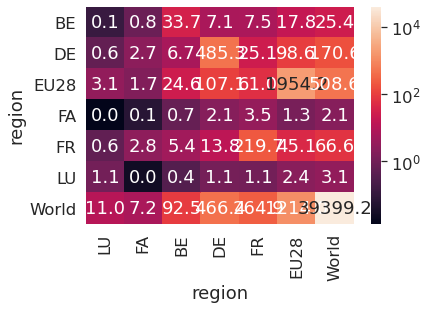

In [289]:
GWP_territorial_summary = GWP_territorial.groupby('region',axis=1).sum().groupby('region',axis=0).sum().reindex(reg_agg_names, axis=1)*1e-9
sns.heatmap(GWP_territorial_summary, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=GWP_territorial_summary.min().min(),
                                           vmax=GWP_territorial_summary.max().max()),
           fmt='.1f')

In [290]:
GWP_territorial_summary.sum()

region
LU          16.563103
FA          15.345837
BE         164.107161
DE        1082.796767
FR         582.774998
EU28      3333.436699
World    40175.727360
dtype: float64

In [209]:
GWP_territorial_Y = ioagg.impact.F_Y.loc[ind]

GWP_territorial_Y = pd.DataFrame(
    block_diag(*[GWP_territorial_Y.iloc[i*n_sectors_Y:(i+1)*n_sectors_Y] for i in range(7)]),
            index = ioagg.get_regions(),
            columns = GWP_territorial_Y.index).groupby('region',axis=1).sum()*1e-9
GWP_territorial_Y

region,BE,DE,EU28,FA,FR,LU,World
region,,,,,,,
LU,0.000000,0.000000,0.000000,0.000000,0.0000,1.459453,0.000000
FA,0.000000,0.000000,0.000000,2.516956,0.0000,0.000000,0.000000
BE,25.168684,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000
DE,0.000000,186.761579,0.000000,0.000000,0.0000,0.000000,0.000000
FR,0.000000,0.000000,0.000000,0.000000,95.0158,0.000000,0.000000
EU28,0.000000,0.000000,527.034567,0.000000,0.0000,0.000000,0.000000
World,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,5153.056494


In [ ]:
GWP_territorial_all_summary = (GWP_territorial_summary \
                               + GWP_territorial_Y.groupby('region').sum()) \
                                .reindex(reg_agg_names) \
                                .reindex(reg_agg_names,axis=1)
GWP_territorial_all_summary

In [ ]:
GWP_all_toplot  = GWP_territorial_all_summary.applymap(lambda x: round(x, int(np.floor(1 - np.floor(np.log10(x))))))
GWP_prod_toplot  = [*zip(GWP_territorial_all_summary.sum(1).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x)))))))]
GWP_cons_toplot  = [GWP_territorial_all_summary.sum(0).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]
GWP_total_toplot = [pd.Series(GWP_territorial_all_summary.sum().sum()).apply(lambda x: round(x, int(np.floor(2 - np.floor(np.log10(x))))))]

GWP_cons_toplot

NameError: name 'GWP_all_toplot' is not defined

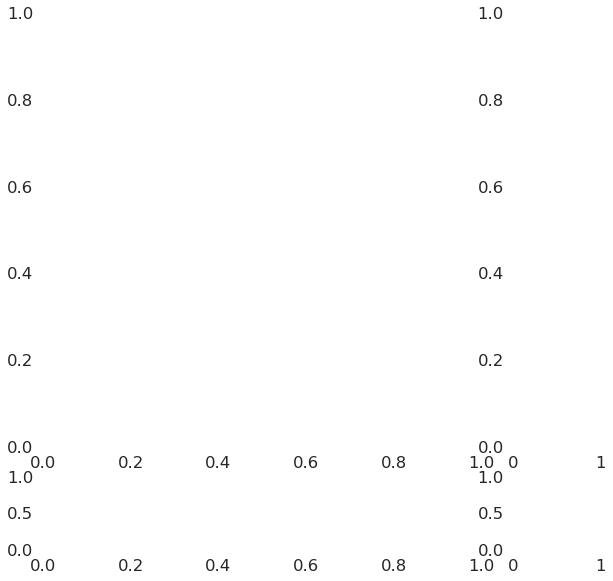

In [266]:
sns.set(font_scale=1.5)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(10, 745/88),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 2],
                                    'height_ratios': [10, 745/888*2],
                                    'wspace': 0.12,
                                    'hspace': 0.12,
                                    'bottom': 0})

cmap  = 'viridis_r'


sns.heatmap(GWP_all_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=1,
                                           vmax=GWP_territorial_all_summary.max().max()),
           fmt='g',
            cmap=cmap,
            cbar=False,
           ax=ax[0,0])

sns.heatmap(GWP_prod_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GWP_territorial_all_summary.max().max()),
            
            cmap=cmap,
           fmt='g',
           ax=ax[0,1])

sns.heatmap(GWP_cons_toplot, annot=True,
#             annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GWP_territorial_all_summary.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='g',
           ax=ax[1,0])

sns.heatmap(GWP_total_toplot, annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GWP_territorial_all_summary.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='g',
           ax=ax[1,1])

ax[0,0].set_xlabel('TO')
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_ylabel('FROM')
ax[0,0].set_title('GHG flows embodied in trade, Mt CO$_2$ eq., 2018')
ax[0,0].xaxis.tick_top()
ax[0,0].tick_params(axis=u'both', which=u'both',length=0)

ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_ylabel('EMBODIED IN PRODUCTION')

ax[1,1].set_xlabel('')
ax[1,1].set_xticks([])
ax[1,1].set_xlabel('TOTAL, WORLD',labelpad=8)
ax[1,1].xaxis.set_label_position('top') 

ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION',labelpad=8)
ax[1,0].xaxis.set_label_position('top') 
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])
ax[1,0].set_xticklabels([])
ax[1,0].set_xticks([])

hili=0
ax[0,0].add_patch(Rectangle((0, hili), 7, 2, fill=False, edgecolor='darkgreen', lw=3))
ax[0,0].add_patch(Rectangle((hili, 0), 2, 7, fill=False, edgecolor='darkgreen', lw=3))
ax[0,1].add_patch(Rectangle((0, hili), 1, 2, fill=False, edgecolor='darkgreen', lw=3))
ax[1,0].add_patch(Rectangle((hili, 0), 2, 1, fill=False, edgecolor='darkgreen', lw=3))


# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.svg'.format(year),
            facecolor='white',
            edgecolor='none',
            bbox_inches='tight')

### Aggregate and disaggregate for the functional area, Luxembourg included (population-wise, i.e. only consumption-based would make sense)
We need a 49 to 3 matrix, to reaggregate for Luxembourg + functional area, EU28, and rest of the world.

<AxesSubplot:xlabel='region'>

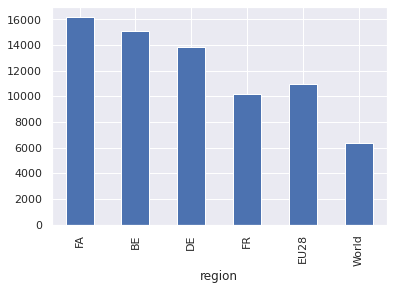

In [265]:
reg_agg_matrix = np.zeros([49,6])

# We'll disaggregate the various countries to compose the functional area
# Flows will follow population, for a lack of a better proxy for emissions
# This is probably wrong for territorial emissions, but should hold for consumption

population_FA=pd.Series({'LU':io.population['LU'],
                         'BE':225772,
                         'DE':378881,
                         'FR':781852},
                          name='population')

FA_shares=population_FA/io.population
FA_shares.fillna(inplace=True, value=0)
FA_shares=FA_shares.reindex_like(io.population)

reg_agg_matrix[:,0] = FA_shares
reg_agg_matrix[io.get_regions()=='BE',1] = 1-reg_agg_matrix[io.get_regions()=='BE',1]
reg_agg_matrix[io.get_regions()=='DE',2] = 1-reg_agg_matrix[io.get_regions()=='DE',1]
reg_agg_matrix[io.get_regions()=='FR',3] = 1-reg_agg_matrix[io.get_regions()=='FR',1]
reg_agg_matrix[:28,4] = 1-reg_agg_matrix[:28,:4].sum(1)
reg_agg_matrix[:,5] = 1-reg_agg_matrix[:,:5].sum(1)

reg_agg_matrix=reg_agg_matrix.T # argh, the matrix was transposed

assert all(reg_agg_matrix.sum(0)==1)

# Reaggregate
reg_agg_names=['FA','BE','DE','FR','EU28','World']
ioagg = io.aggregate(region_agg=reg_agg_matrix,
                     region_names=reg_agg_names,
                        inplace=False)

# Calculate the new system
ioagg.calc_all()

ioagg.calc_extensions()

ioagg.impact.D_cba_cap.loc[ind].plot(kind='bar')

## Heatmap of global (or EU) GHG emissions embodied in trade

In [ ]:
sns.set(font_scale=1)

n_sectors   = 163
n_sectors_Y = 7

method = GWP100_unfccc # in case you set up other method vectors

# create the GHG factors in GWP100 
S_GWP   = method.dot(io.satellite.S.loc[method.index])
F_GWP_Y = method.dot(io.satellite.F_Y.loc[method.index])
S_GWP   = io.impact.S.loc[ind]
F_GWP_Y = io.impact.F_Y.loc[ind]

# and calculate the greenhouse gas emissions per sector of consumption for the intermediate consumption
GHG_cons_total = io.L.multiply(S_GWP,axis=0).dot(io.Y)

# group by region (we don't want sector resolution) and convert to Mt
GHG_cons_to_plot = GHG_cons_total.groupby('region',
                                    axis=1).sum().groupby('region',
                                                           axis=0).sum().reindex(io.get_regions(),
                                                                                 axis=0).reindex(io.get_regions(),
                                                                                                 axis=1)*1e-9

# same, for the emissions of final demand
GHG_cons_Y = pd.DataFrame(block_diag(*[F_GWP_Y.iloc[i*n_sectors_Y:(i+1)*n_sectors_Y] for i in range(49)]),
            index   = io.get_regions(),
            columns = io.Y.columns)
GHG_cons_Y_to_plot = GHG_cons_Y.groupby('region',axis=1).sum().reindex(io.get_regions(), axis=1)*1e-9

# sum them both
GHG_cons = GHG_cons_to_plot + GHG_cons_Y_to_plot

# and create column and row for production-based emissions and consumption-based emissions 
GHG_cons['EMBODIED IN\nPRODUCTION'] = GHG_cons.sum(1)
GHG_cons.loc['EMBODIED IN\nCONSUMPTION'] = GHG_cons.sum()

In [ ]:
max_r = 49 # EU = 28, All = 49
cmap  = 'viridis'

GHG_cons_cutoff=GHG_cons.drop(GHG_cons.index[max_r:-1],axis=0).drop(GHG_cons.columns[max_r:-1],axis=1)

GHG_cons_sorted=GHG_cons_cutoff.sort_values(by='EMBODIED IN\nCONSUMPTION', axis=1)
GHG_cons_sorted=GHG_cons_sorted.reindex([*GHG_cons_sorted.columns[:-1],'EMBODIED IN\nCONSUMPTION'], axis=0)

fig, ax = plt.subplots(ncols=2,
                       nrows=2,
                       figsize=(30, 20),
                       subplot_kw={'facecolor':'w'},
                       gridspec_kw={'width_ratios': [10, 1],
                                    'height_ratios': [10, 1],
                                    'wspace': 2/3*0.05,
                                    'hspace': 0.05,
                                    'bottom': 0})

sns.heatmap(GHG_cons_sorted.iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,0])
sns.heatmap(GHG_cons_sorted[GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            
            cmap=cmap,
           fmt='.0f',
           ax=ax[0,1])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:]].iloc[:max_r,:max_r], annot=True,
            annot_kws={'rotation': 90},
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
           fmt='.0f',
           ax=ax[1,0])
sns.heatmap(GHG_cons_sorted.loc[GHG_cons.index[-1:],GHG_cons.columns[-1:]].iloc[:max_r,:max_r], annot=True,
            norm=matplotlib.colors.LogNorm(vmin=.05,
                                           vmax=GHG_cons.max().max()),
            cbar=False,
            cmap=cmap,
            yticklabels=[],
            xticklabels=['GLOBAL EMISSIONS'],
           fmt='.0f',
           ax=ax[1,1])

ax[1,1].set_xlabel('')
ax[1,0].set_xlabel('EMBODIED IN CONSUMPTION')
ax[1,0].set_ylabel('')
ax[1,0].set_yticklabels([])

# resize the corner box
ax01pos = ax[0,1].get_position().bounds
ax11pos = list(ax[1,1].get_position().bounds)
ax11pos[2] = ax01pos[2]
ax[1,1].set_position(ax11pos)

fig.savefig('GHG_in_trade_{}.png'.format(year),
            facecolor='white',
            edgecolor='none')